# Topical lecture June 2024: Damping a Triple suspension

### In this exercise you will investigate different methods for damping the longitudinal modes of an triple suspension (similar to an HRTS but bigger) used in the LIGO gravitational-wave detectors.

You will be given the longitudinal transfer functions of a modelled *undamped* triple suspension. You will see that while the passive attenuation alone is great at suppressing motion at high frequency (above the highest resonance of the suspension) but it actually magnifies *a lot* the motion near the resonances. 

You will then model the addition of control filters to damp the suspension resonances by sensing and actuating on different stages of the suspension. 

**The overall aim is answering the following questions:**
* Can you damp the resonances enough to reduce the overall rms motion (down to 0.1 Hz) of the mirror below the level of the seismic isolation platform the suspension is attached to (2e-8 m)? 
* Does the damped suspension still suppress motion to the level required for GW detection? (1e-18 m/sqrt[Hz] above 10 Hz, where the GW detectors detection band starts).
* Is actuating on M1 or on M3 better to achieve this purposes?



**To answer the above questions, the notebook has been split in the following tasks: (more detailed in the notebook):**
1. [Reconstruct the complete transfer function of ground vibration to mirror motion given transfer functions between each stage of the suspension. Compare the resulting rms mirror motion with respect to the platform motion where the suspension is suspended from.](#first-bullet)
2. [Build a controller to actively damp the suspension resonances actuating directly on the mirror, use the Open-Loop transfer function and the Closed-Loop transfer function to assess the controller stability and to optimize it.](#second-bullet)
3. [Do the same as in step 2, but this time actuate on the intermediate mass of the suspension.](#third-bullet)
4. [Check and compare the ground-to-mirror transfer functions of the damped plants from steps 2 and 3. Project a given ground motion spectra to compute its residual mirror motion contribution. Compare the different damping and undamped cases.](#fourth-bullet)
5. [Compute the sensing noise to mirror-motion transfer functions for the control-loops built in step 2 and 3. Project also the sensing noise to obtain its contribution to the residual mirror motion. Sum it to the spectras computed in 4. and compute and compare the total residual mirror motion](#fifth-bullet)

## **Note: keep the variable names provided in the answer cells, or the rest of the code will break**

# The Triple suspension
The Triple suspension is a gloryfied triple pendulum. In the case of the LIGO beamsplitter suspension, the suspension is attached from the top to a seismic isolation platform which already partially filters the ground motion. The image below shows the three suspended masses of the triple suspension (on the left) and a CAD image of the full triple suspension including the external cage where the sensors and the actuators are placed (on the right).

![Triple_suspension_scheme](triple_jesse.png)

Image from J. van Dongen et al. Reducing control noise in gravitational wave detectors with
interferometric local damping of suspended optics. https://doi.org/10.1063/5.0144865

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control
import control.matlab
import scipy.signal as sig 

## 1. Transfer function of platform to mirror vibration: <a class="anchor" id="first-bullet"></a>

The the behaviour of the suspension above has been thoroughly modeled in all 6 degrees of freedom of each stage, resulting in a 18-dimensional state-space model which includes couplings between different degrees of freedom. (See for example Mark Barton's models here for more details: https://labcit.ligo.caltech.edu/~e2e/SUSmodels/intro.html)

For the sake of simplicity of this exercise, we will consider only the "longitudinal" displacement degree of freedom with no cross-couplings, by longitudinal we mean the direction of the laser beam hitting the mirror M3 orthogonally to its faces, and therefore the DoF which mostly affects the interferometer sensitivity.

In the cell below there are listed the longitudinal transfer functions between force applied on each stage and the corresponding displacement of each stage itself or of the next stage in the suspension chain (e.g. from force applied on M1 and the correspondin M2 displacement). 

The transfer functions are defined using lists of complex zeros, poles and a gain.
To visualize them you can plot them by sampling them using the control.frequency_response() method

**Exercise 1:**
* Combine the different transfer functions given below to obtain the total transfer function from Platform motion to Mirror motion
* Compare the result with the provided combined transfer function.
* Use the above transfer function to project the given platform-motion Amplitude Spectral Density (ASD) to the resulting mirror residual motion ASD $Axx$. Compare the mirror motion with the platform motion ASD.
* Compute and compare the total rms of the residual displacements $SNR_x = \sqrt{\sum_i {Axx_i}^2 \Delta f_i}$ for the platform and the suspended mirror. Which one is the lowest?

Hints:
* Hint: To build a force-to-force TF you can invert some of the force-to-displacement TFs, e.g. to get m1 force to m2 force you can combine m1_to_m2 *(1/f_to_d_m1)
* Hint 2: Use control.matlab.minreal() on the combined transfer function to simplify zeroes and poles that should cancel eachother out and avoid an excessive amount of numerical errors. You can set a tolerance of 1e-3 or 1e-2 to cancel poles and zeroes that are not exactly at the same frequency but very close.

In [2]:
# Triple Suspension individual masses Transfer Functions, defined using zeroes, poles and gain of their complex polynomial.
# Don't be scared, they don't bite, usually. 
#([zeroes],
# [poles],
# gain)

#################################
# Platform to mass 1, displacement to displacement (NOTE, THIS IS THE ONLY DISPLACEMENT-TO-DISPLACEMENT TF PROVIDED, ALL OTHERS ARE FORCE TO DISPLACEMENT!)
plt_to_m1 = control.zpk([(-0.0004998564156727421+9.220626591369038j), (-0.0004998564156727421-9.220626591369038j), (-0.0004990071444764436+3.218716397889035j), (-0.0004990071444764436-3.218716397889035j)],
 [(-0.0004999836029240517+11.975570190829144j), (-0.0004999836029240517-11.975570190829144j), (-0.0004997365237082739+7.341578964187666j), (-0.0004997365237082739-7.341578964187666j), (-0.0004991434335209103+2.633601872905462j), (-0.0004991434335209103-2.633601872905462j)],
 60.864389150482054)

#################################

#################################
# Mass 1 to mass 2, force to displacement
m1_to_m2 = control.zpk([(4215954.538766596+0j), (-4215954.534697399+0j), (-0.0004999999995384406+4.4365156817854485j), (-0.0004999999995384406-4.4365156817854485j)],
 [(-0.0005000000000749943+11.976346578033302j), (-0.0005000000000749943-11.976346578033302j), (-0.0004999999996464247+7.336075539822558j), (-0.0004999999996464247-7.336075539822558j), (-0.0004999999998127507+2.627597839194587j), (-0.0004999999998127507-2.627597839194587j)],
 -1.9895196601282805e-13)

#################################
# Mass 2 to mass 3, force to displacement
m2_to_m3 = control.zpk([(0.1338359375089304+1459219.1028394247j), (0.1338359375089304-1459219.1028394247j), (-0.0005000000302902339+10.461157024793497j), (-0.0005000000302902339-10.461157024793497j), (-0.0004999999778277099+9.603181110173919j), (-0.0004999999778277099-9.603181110173919j), (-0.0005000000008423353+7.448761586584852j), (-0.0005000000008423353-7.448761586584852j), (-0.0005000000000292973+2.94651706784492j), (-0.0005000000000292973-2.94651706784492j)],
 [(-0.000499999999998944+11.97653487180178j), (-0.000499999999998944-11.97653487180178j), (-0.0004999999999818378+9.610144747262886j), (-0.0004999999999818378-9.610144747262886j), (-0.0004999999996983891+7.466808935056245j), (-0.0004999999996983891-7.466808935056245j), (-0.0005000000001174417+7.313732112545643j), (-0.0005000000001174417-7.313732112545643j), (-0.0004999999998704857+2.981074913516356j), (-0.0004999999998704857-2.981074913516356j), (-0.0005000000000766822+2.592152025330844j), (-0.0005000000000766822-2.592152025330844j)],
 6.821210263296962e-13)


#################################
#Force on mass 1 to displacement on mass 1
f_to_d_m1 = control.zpk([(-0.000499999999797377+9.219466492014044j), (-0.000499999999797377-9.219466492014044j), (-0.0004999999996428464+3.219318774894932j), (-0.0004999999996428464-3.219318774894932j)],
 [(-0.0004999999999639796+11.9755701902514j), (-0.0004999999999639796-11.9755701902514j), (-0.000499999999742727+7.341578943783805j), (-0.000499999999742727-7.341578943783805j), (-0.0004999999997344826+2.633601645607727j), (-0.0004999999997344826-2.633601645607727j)],
 0.07923930269402035)

#################################
#Force on mass 2 to displacement on mass 2
f_to_d_m2 = control.zpk([(-0.0004999999999726706+10.455638457428407j), (-0.0004999999999726706-10.455638457428407j), (-0.0005000000000022808+4.440786459208819j), (-0.0005000000000022808-4.440786459208819j)],
 [(-0.0004999999999870508+11.976346579768592j), (-0.0004999999999870508-11.976346579768592j), (-0.0004999999999773559+7.336075526929193j), (-0.0004999999999773559-7.336075526929193j), (-0.000500000000009445+2.6275978199219856j), (-0.000500000000009445-2.6275978199219856j)],
 0.07363770250333346)

#################################
#Force on mass 3 to displacement on mass 3
f_to_d_m3 = control.zpk([(-0.0005000000062999168+11.90777466723931j), (-0.0005000000062999168-11.90777466723931j), (-0.0004999999945308684+9.609716604555537j), (-0.0004999999945308684-9.609716604555537j), (-0.0005000000018158807+7.452560839771179j), (-0.0005000000018158807-7.452560839771179j), (-0.0004999999994034349+6.523304352631114j), (-0.0004999999994034349-6.523304352631114j), (-0.0005000000000064012+2.9465235507300815j), (-0.0005000000000064012-2.9465235507300815j)],
 [(-0.0004999999999975526+11.97653487179943j), (-0.0004999999999975526-11.97653487179943j), (-0.00050000000002101+9.610144747295472j), (-0.00050000000002101-9.610144747295472j), (-0.0005000000002113554+7.4668089352353455j), (-0.0005000000002113554-7.4668089352353455j), (-0.0004999999999179763+7.313732112470431j), (-0.0004999999999179763-7.313732112470431j), (-0.0005000000000006065+2.9810749129172986j), (-0.0005000000000006065-2.9810749129172986j), (-0.0005000000000056734+2.592152025797092j), (-0.0005000000000056734-2.592152025797092j)],
 0.047641734159299176)

#################################

### Answer:

In [3]:
platform_to_mirror_concatenated_plant = control.minreal(m2_to_m3 *1/f_to_d_m2* m1_to_m2 *1/f_to_d_m1* plt_to_m1, 1e-2)

22 states have been removed from the model


/data/gravwav/topical_lecture_2024/conda_env/top_lect_shared/lib/python3.12/site-packages/scipy/signal/_filter_design.py:1109: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


In [4]:
#The resuslting transfer function should be similar to this one : 
platform_to_mirror_plant = control.zpk([(4977.342914136168+4973.05266081832j),
                                      (4977.342914136168-4973.05266081832j),
                                      (-4974.371360950271+4973.050962925495j),
                                      (-4974.371360950271-4973.050962925495j),
                                      (3.2230492711866725e-06+201.06650276014497j),
                                      (3.2230492711866725e-06-201.06650276014497j),
                                      (8.83764063249334e-06+123.37960883328674j),
                                      (8.83764063249334e-06-123.37960883328674j),
                                      (-5.4689656348108495e-15+9.609785045454437j),
                                      (-5.4689656348108495e-15-9.609785045454437j),
                                      (-2.920043316739897e-16+7.441118388045376j),
                                      (-2.920043316739897e-16-7.441118388045376j),
                                      (1.5951371518881691e-16+2.9375836854830313j),
                                      (1.5951371518881691e-16-2.9375836854830313j)],
 [(-3.193047963119924e-10+201.0666092937019j),
  (-3.193047963119924e-10-201.0666092937019j),
  (9.013698488047454e-06+123.37960561401175j),
  (9.013698488047454e-06-123.37960561401175j),
  (-4.496512213271527e-16+11.97653488223958j),
  (-4.496512213271527e-16-11.97653488223958j),
  (-5.156822288721808e-15+9.610144760246948j),
  (-5.156822288721808e-15-9.610144760246948j),
  (5.0739569628476915e-15+7.466808951241168j),
  (5.0739569628476915e-15-7.466808951241168j),
  (-4.440892105118071e-15+7.3137321298474545j),
  (-4.440892105118071e-15-7.3137321298474545j),
  (-7.632986449856394e-16+2.9810749548412114j),
  (-7.632986449856394e-16-2.9810749548412114j),
  (7.703529677891511e-16+2.592152073963035j),
  (7.703529677891511e-16-2.592152073963035j)],
 2.1827872842550278e-11)

### Compare the ground-to-mirror transfer function with the one you concatenated:
Most important things that have to match:
* DC level (0 Hz) asymptotic to ~ 1
* Number and frequency of resonance peaks
* Suppression steepness above the highest resonance peak.  

In [5]:
# One easy way to compare the transfer functions is to visualize them on a bode plot after sampling them:
Frequency_Array = np.logspace(-1, 2, int(1e5)) # Do not modify these arrays since they need to match the ISI spectra imported in the next steps.
Omega_Array = Frequency_Array * (2*np.pi)
p_to_m_sampled = control.frequency_response(platform_to_mirror_plant, Omega_Array)
p_to_m_concatenated_sampled = control.frequency_response(platform_to_mirror_concatenated_plant, Omega_Array)

(0.1, 20)

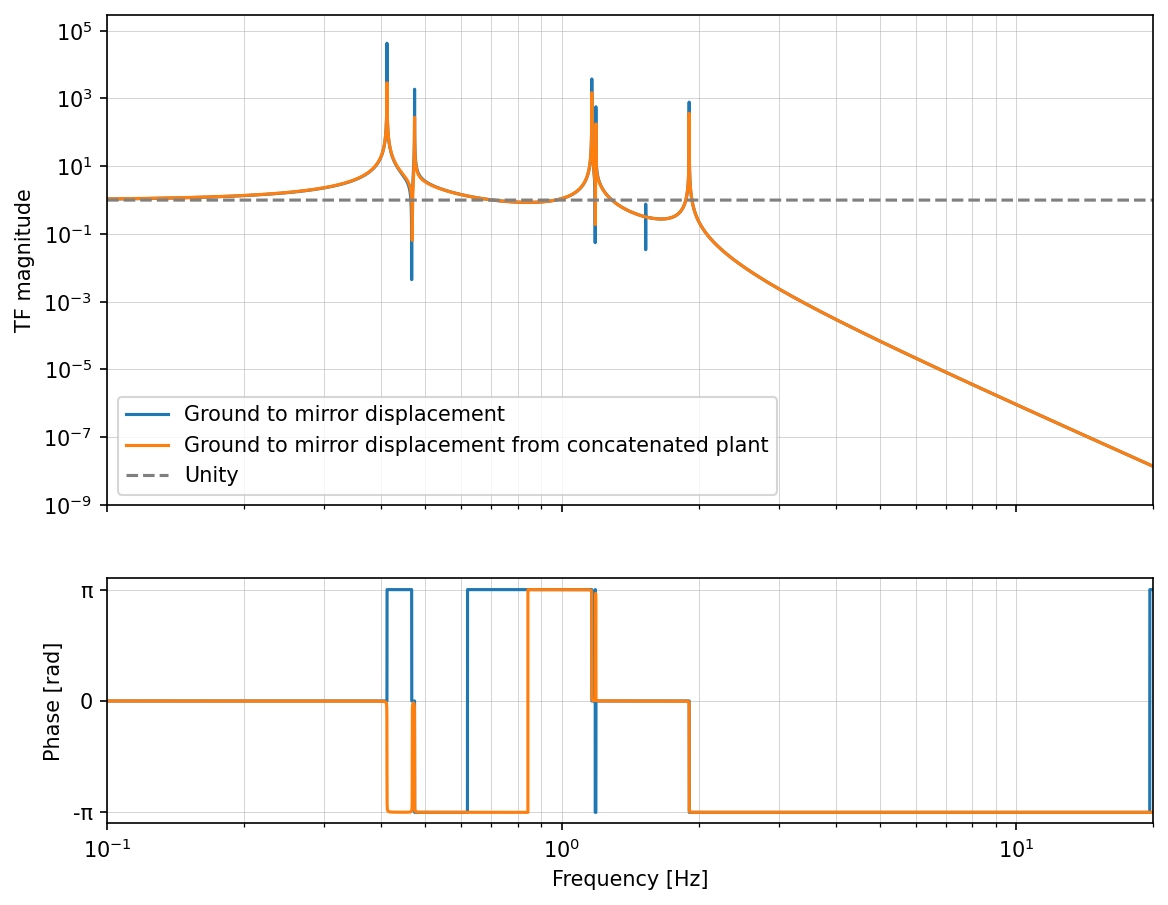

In [6]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(9, 7), dpi = 150, sharex=True)


a0.loglog(Frequency_Array, np.squeeze(p_to_m_sampled.magnitude), label = 'Ground to mirror displacement')
a0.loglog(Frequency_Array, np.squeeze(p_to_m_concatenated_sampled.magnitude), label = 'Ground to mirror displacement from concatenated plant')
a0.loglog(Frequency_Array, np.ones_like(Frequency_Array), label = 'Unity', color = 'grey', linestyle='--')

a0.set_ylabel('TF magnitude')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_xlim(1e-1, 20)
a0.set_ylim(1e-9, )


a1.semilogx(Frequency_Array, np.squeeze(p_to_m_sampled.phase))
a1.semilogx(Frequency_Array, np.squeeze(p_to_m_concatenated_sampled.phase))
a1.grid(True, which = 'both', linewidth = .25)
a1.set_xlabel('Frequency [Hz]')
a1.set_ylabel('Phase [rad]')
a1.set_yticks([-np.pi, 0, np.pi], labels = ["-π", 0, "π"])
a1.set_xlim(1e-1, 20)

### Load the platform motion ASD and project it to obtain the the mirror M3 motion

True


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_37198/3866483378.py:10: SyntaxWarning: invalid escape sequence '\s'
  a0.set_ylabel('Ground motion ASD $[m / \sqrt{Hz}]$')


Text(0.5, 0, 'Frequency [Hz]')

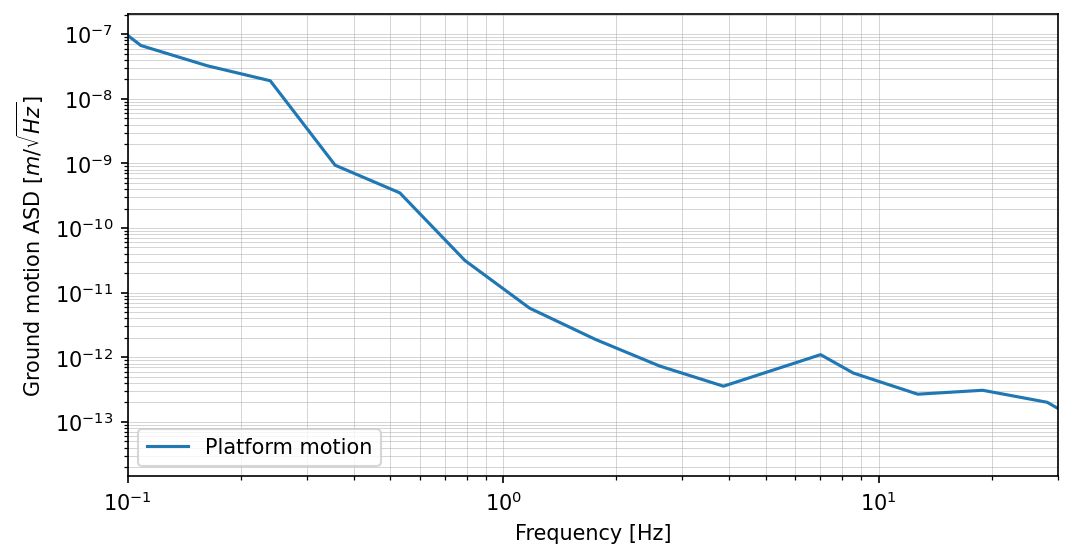

In [7]:
freqs, platform_motion = np.loadtxt('ISInoise.txt')

# Check that freqs matches the above defined frequency array: 
print(np.allclose(freqs, Frequency_Array, 1e-5))

# Plot it to have an idea of how it looks like:
f, a0 = plt.subplots(1, 1, figsize=(8, 4), dpi = 150)

a0.loglog(freqs, platform_motion , label = 'Platform motion')
a0.set_ylabel('Ground motion ASD $[m / \sqrt{Hz}]$')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_xlim(1e-1, 30)
a0.set_xlabel('Frequency [Hz]')

In [8]:
#Project the noise to the mirror: 
mirr_motion_undamped = platform_motion*np.squeeze(p_to_m_concatenated_sampled.magnitude)

In [9]:
def cumulative_rms(asd, frequencies):
    return np.sqrt(np.cumsum(asd[1:][::-1]**2*np.diff(frequencies)[::-1])[::-1])

In [10]:
platform_motion_rms = cumulative_rms(platform_motion, freqs)
mirr_motion_undamped_rms = cumulative_rms(mirr_motion_undamped, freqs)

print(f'Platform motion rms = {platform_motion_rms[0]:.4e} m')
print(f'Mirror motion rms = {mirr_motion_undamped_rms[0]:.4e} m')

Platform motion rms = 1.5187e-08 m
Mirror motion rms = 3.5267e-08 m


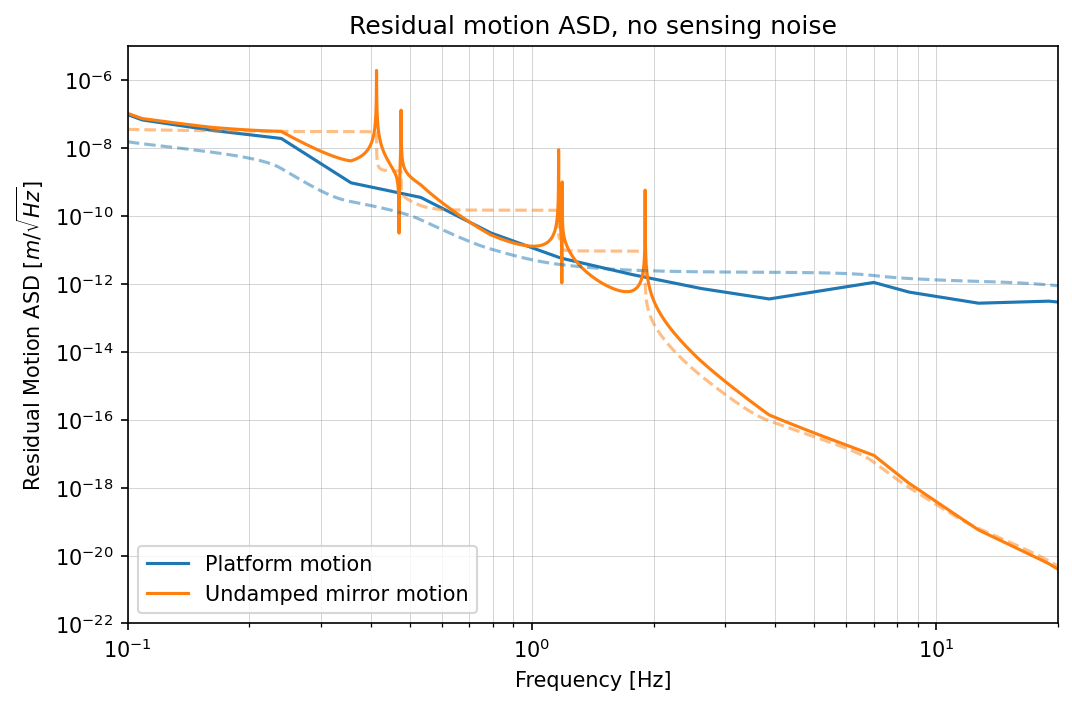

In [11]:
f, a0 = plt.subplots(1, 1, figsize=(8, 5), dpi = 150)

a0.loglog(freqs, platform_motion , label = 'Platform motion')
a0.loglog(freqs, mirr_motion_undamped , label = 'Undamped mirror motion')

# Add the RMS
a0.loglog(freqs[1:], platform_motion_rms ,  linestyle='--', color='C0', alpha=0.5)
a0.loglog(freqs[1:], mirr_motion_undamped_rms , linestyle='--', color='C1', alpha=0.5)

a0.set_title('Residual motion ASD, no sensing noise')
a0.set_ylabel(r'Residual Motion ASD $[m/\sqrt{Hz}]$')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_xlim(1e-1, 20)
a0.set_ylim(1e-22, 1e-5 )
a0.set_xlabel('Frequency [Hz]')


plt.show()

## 2. Damp the suspension by actuating on the mirror: <a class="anchor" id="second-bullet"></a>
The transfer functions above shows the following interesting features:
* Transmission of motion above ~2 Hz is greatly suppressed (and this is why we use it)
* Transmission of motion below ~0.2 Hz tends to unity (1)
* **Motion is greatly amplified near the resonance peaks of the pendulum system!**

Problem 3 is the main problem of fully passive systems, while they are good at suppressing motion above a certain frequency, they enhance a lot the platform motion at their resonance! 

**To solve this, an active damping of the resonance can be implemented.**

**Exercise 2:** 
* Suppose you have a sensor that measures the mirror motion, design a control filter that uses the signal from this sensor to actuate on the mirror itself (M3) to damp the suspension resonances.
* Define the lot the open- and closed-loop and controlled plant transfer functions for this control system.

Hints:
* Given $G[s]$ being the plant in the control loop, and $H[s]$ the controller, the open loop transfer function is defined as $1/(1-G[s]H[s])$ and the closed loop transfer function as $G[s]H[s]/(1-G[s]H[s])$ and the 'controlled plant' transfer function is $G[s]/(1-G[s]H[s])$  (this 'controlled plant' is often what is referred as the real closed loop transfer function.
* Use the scheme below to determine which are G and H. (By ground motion we mean platform motion). 
* You can make a basic filter using only (negative) real poles and zeroes. Note that the zpk values are in radians and not in Hz.
* Use the is_stable() function defined below to check that the controlled plant is stable, by checking that all its poles lie in the left half-plane (negative real part). 
* Use the bode-plot and the control.stability_margins() function to check the Open-Loop TF phase and gain margins.
* Optional: use control.impulse_response to visualize the effect of the damping filters

### Actuation on M3 Scheme
![Loop_m3_act](topical_lecture_m3_act_noiseless.drawio.png)

In [12]:
def is_stable(controlled_plant):
    # Checks that all poles are in the open left half of the complex plane
    print(np.all(controlled_plant.poles() < 0))

## Answer:

In [13]:
control_m3 = control.zpk([-0.2, -0.2, -0.3],[0, -25, -15, -25], 500000)

# Actuation on mirror:
open_loop_m3_act = f_to_d_m3 * control_m3 # Assuming sensing directly on M3 and torque actuation on M3

controlled_plant_m3_act = f_to_d_m3 /(1 + open_loop_m3_act)
closed_loop_m3_act = open_loop_m3_act /(1 + open_loop_m3_act)

In [14]:
# Check stability and margins:
is_stable(controlled_plant_m3_act)
print(control.stability_margins(open_loop_m3_act)) 

True
(3.199024363485087, -39.038051303905576, 0.5147287336720595, 36.53042895272205, 1.5064406092875708, 26.586403500797633)


In [15]:
# Sample the Transfer functions for the plotting:

In [16]:
control_m3_sampled = control.frequency_response(control_m3, Omega_Array)
open_loop_m3_act_sampled = control.frequency_response(open_loop_m3_act, Omega_Array)
closed_loop_m3_act_sampled = control.frequency_response(closed_loop_m3_act, Omega_Array)
plant_m3_sampled = control.frequency_response(f_to_d_m3, Omega_Array)
controlled_plant_m3_act_sampled = control.frequency_response(controlled_plant_m3_act, Omega_Array)

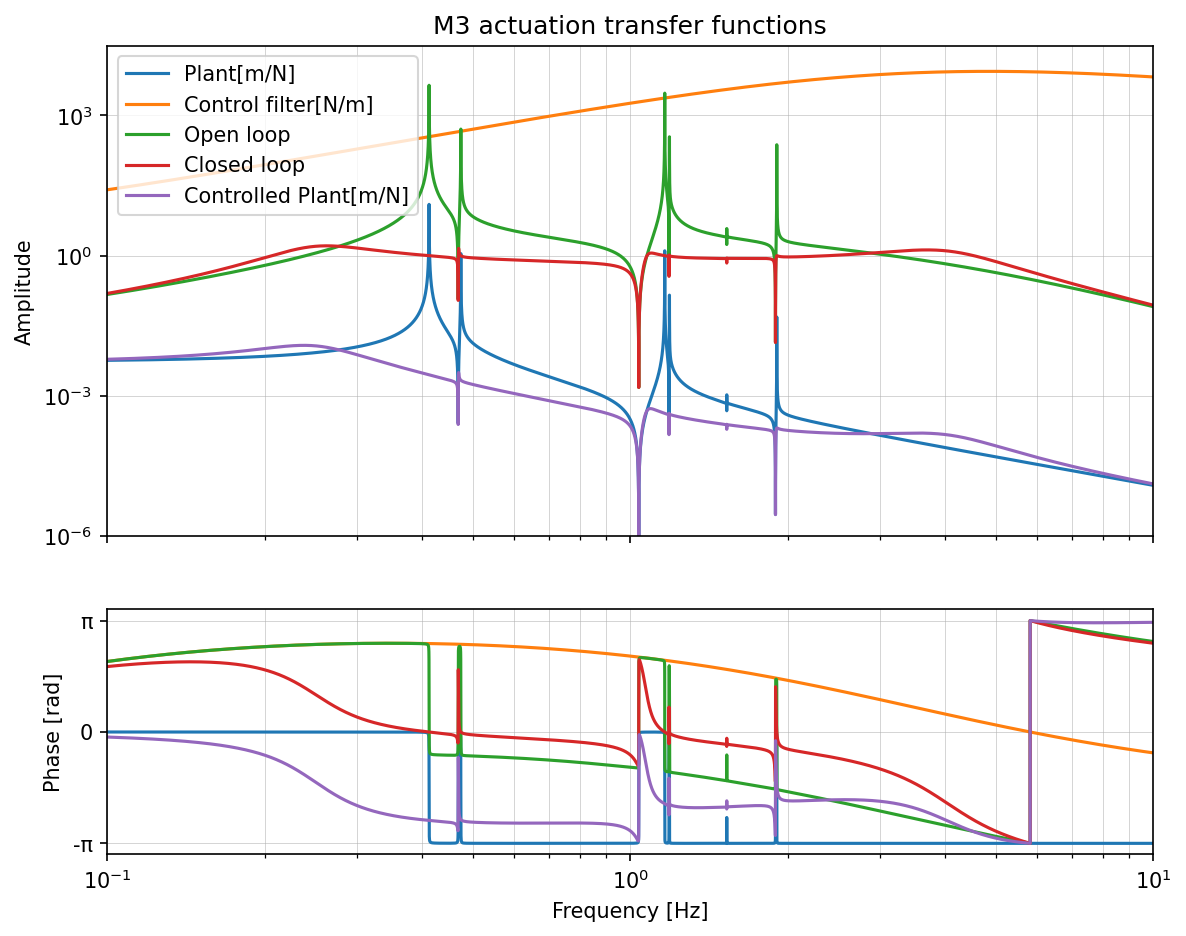

In [17]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(9, 7), dpi = 150, sharex=True)
a0.loglog(Frequency_Array, np.squeeze(plant_m3_sampled.magnitude), label = 'Plant[m/N]')
a0.loglog(Frequency_Array, np.squeeze(control_m3_sampled.magnitude), label = 'Control filter[N/m]')
a0.loglog(Frequency_Array, np.squeeze(open_loop_m3_act_sampled.magnitude), label = 'Open loop')
a0.loglog(Frequency_Array, np.squeeze(closed_loop_m3_act_sampled.magnitude), label = 'Closed loop')
a0.loglog(Frequency_Array, np.squeeze(controlled_plant_m3_act_sampled.magnitude), label = 'Controlled Plant[m/N]')


a0.set_ylabel('Amplitude')
a0.legend(loc = 'upper left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_yticks([1e-6, 1e-3, 1, 1e3])
a0.set_xlim(1e-1, 10)
a0.set_ylim(1e-6, )
a0.set_title('M3 actuation transfer functions')
a1.semilogx(Frequency_Array, np.squeeze(plant_m3_sampled.phase), label = 'Plant')
a1.semilogx(Frequency_Array, np.squeeze(control_m3_sampled.phase), label = 'Control filter')
a1.semilogx(Frequency_Array, np.squeeze(open_loop_m3_act_sampled.phase), label = 'Open loop')
a1.semilogx(Frequency_Array, np.squeeze(closed_loop_m3_act_sampled.phase), label = 'Closed loop')
a1.semilogx(Frequency_Array, np.squeeze(controlled_plant_m3_act_sampled.phase), label = 'Controlled Plant')


a1.grid(True, which = 'both', linewidth = .25)
a1.set_xlabel('Frequency [Hz]')
a1.set_ylabel('Phase [rad]')
a1.set_yticks([-np.pi, 0, np.pi], labels = ["-π", 0, "π"])
a1.set_xlim(1e-1, 10)

plt.show()

## 3. Damp the suspension by actuating on the upper mass. <a class="anchor" id="third-bullet"></a>
In GW interferometers, sensing and actuation is often done not directly on the mirror but on upper stages (spoiler: you'll discover why if you survive until the end of the notebook). Design a control loop that does this.

**Exercise 3:** 
* Similarly to exercise 2, suppose you have a sensor that measures the **Upper Mass M1** motion, design a control filter that uses the signal from this sensor to actuate on the **upper mass (M1)** to damp the suspension resonances.
* plot the open- and closed-loop transfer functions for this control system.


Hints:
* Given $G[s]$ being the plant in the control loop, and $H[s]$ the controller, the open loop transfer function is defined as $1/(1-G[s]H[s])$ and the closed loop transfer function as $G[s]H[s]/(1-G[s]H[s])$ and the 'controlled plant' transfer function is $G[s]/(1-G[s]H[s])$  (this 'controlled plant' is often what is referred as the real closed loop transfer function.
* Use the scheme below to determine which are G and H. (By ground motion we mean platform motion). 
* You can make a basic filter using only (negative) real poles and zeroes. Note that the zpk values are in radians and not in Hz.
* Use the is_stable() function defined below to check that the controlled plant is stable, by checking that all its poles lie in the left half-plane (negative real part). 
* Use the bode-plot and the control.stability_margins() function to check the Open-Loop TF phase and gain margins.
* Optional: use control.impulse_response to visualize the effect of the damping filters


### Sensing and Actuation on M1
![Loop_m1_act](topical_lecture_m1_act_noiseless.drawio.png)

In [18]:
# Control filter to apply directly to the mirror
control_m1 = control.zpk([-0.1, -0.1],[0, -7, -7, -15], 20000)

control_m1 = control.zpk([-0.1, -0.1],[0, -25, -25], 100000)
# Actuation on pem (m2):
open_loop_m1_act = f_to_d_m1 * control_m1 # Assuming sensing directly on M3 and torque actuation on M2

closed_loop_m1_act = open_loop_m1_act/(1 + open_loop_m1_act)
controlled_plant_m1_act = f_to_d_m1 /(1 + open_loop_m1_act)

In [19]:
is_stable(controlled_plant_m1_act)
print(control.stability_margins(open_loop_m1_act))

True
(3.168619468504262, 23.118537293773272, 0.36130631928575324, 24.800434328852823, 16.292625352184633, 17.200495267944707)


In [20]:
control_m1_sampled = control.frequency_response(control_m1, Omega_Array)
open_loop_m1_act_sampled = control.frequency_response(open_loop_m1_act, Omega_Array)
closed_loop_m1_act_sampled = control.frequency_response(closed_loop_m1_act, Omega_Array)
controlled_plant_m1_act_sampled = control.frequency_response(controlled_plant_m1_act, Omega_Array)
plant_m1_sampled = control.frequency_response(f_to_d_m1, Omega_Array)

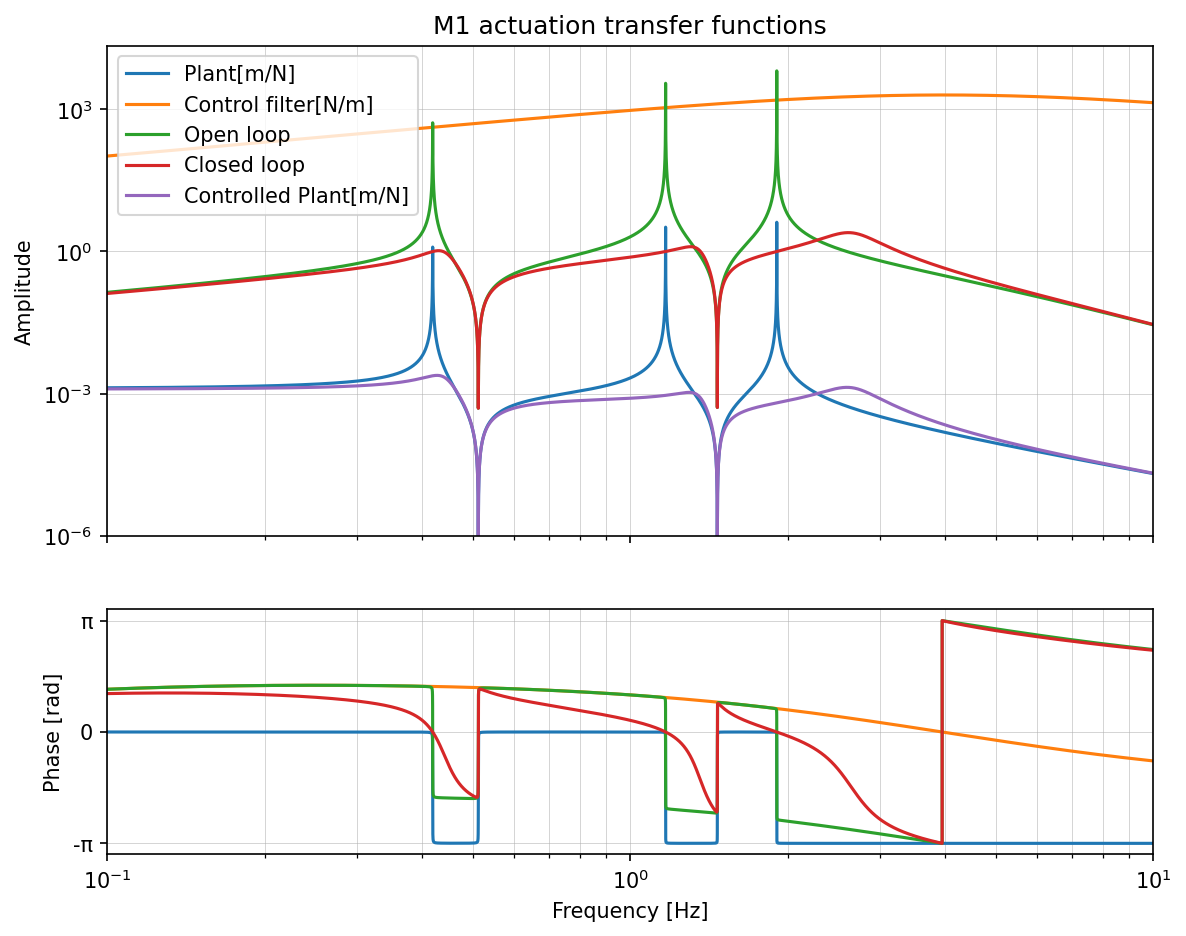

In [21]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(9, 7), dpi = 150, sharex=True)
a0.loglog(Frequency_Array, np.squeeze(plant_m1_sampled.magnitude), label = 'Plant[m/N]')
a0.loglog(Frequency_Array, np.squeeze(control_m1_sampled.magnitude), label = 'Control filter[N/m]')
a0.loglog(Frequency_Array, np.squeeze(open_loop_m1_act_sampled.magnitude), label = 'Open loop')
a0.loglog(Frequency_Array, np.squeeze(closed_loop_m1_act_sampled.magnitude), label = 'Closed loop')
a0.loglog(Frequency_Array, np.squeeze(controlled_plant_m1_act_sampled.magnitude), label = 'Controlled Plant[m/N]')



a0.set_ylabel('Amplitude')
a0.legend(loc = 'upper left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_yticks([1e-6, 1e-3, 1, 1e3])
a0.set_xlim(1e-1, 10)
a0.set_ylim(1e-6, )
a0.set_title('M1 actuation transfer functions')
a1.semilogx(Frequency_Array, np.squeeze(plant_m1_sampled.phase), label = 'Plant')
a1.semilogx(Frequency_Array, np.squeeze(control_m1_sampled.phase), label = 'Control filter')
a1.semilogx(Frequency_Array, np.squeeze(open_loop_m1_act_sampled.phase), label = 'Open loop')
a1.semilogx(Frequency_Array, np.squeeze(closed_loop_m1_act_sampled.phase), label = 'Closed loop')

a1.grid(True, which = 'both', linewidth = .25)
a1.set_xlabel('Frequency [Hz]')
a1.set_ylabel('Phase [rad]')
a1.set_yticks([-np.pi, 0, np.pi], labels = ["-π", 0, "π"])
a1.set_xlim(1e-1, 10)

plt.show()

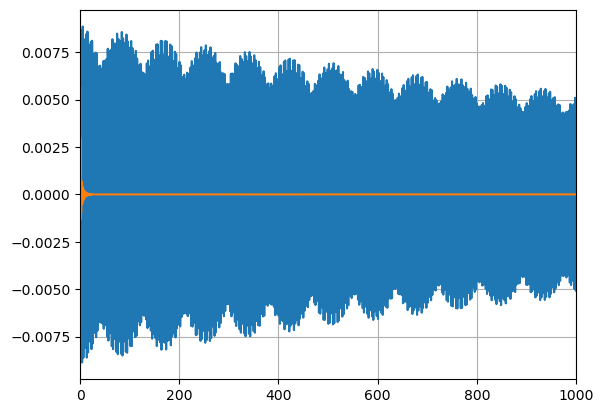

In [22]:
T=np.linspace(0,1000, int(1e5))
u = control.impulse_response(controlled_plant_m1_act, T)
v = control.impulse_response(f_to_d_m1, T)

fig, ax = plt.subplots(1,1)
ax.plot(v.t, np.squeeze(v.y))
ax.plot(u.t, np.squeeze(u.y))

#ax.set_ylim(-1e3, 1e3)
ax.set_xlim(0, 1000)
ax.grid()

## 4. Compare Uncontrolled and Controlled plants <a class="anchor" id="fourth-bullet"></a>:
It is now time to compare how the platform motion is transmitted to the mirror in the damped systems.
The first step is computing the transfer functions of the damped system from platform to mirror. 

**Exercise 4:**
* Build the ground-motion to mirror-motion transfer functions of the two damped systems
* Plot and compare them with the undamped system one.
* Similarly to the last step of Exercise 1, project the platform motion to check the residual mirror M3 motion Amplitude spectra and RMS displacement in the damped cases. Compare them with the undamped case and with the platform motion itself. 

**Which of the sensing and actuation strategies gives the best results? M1 or M3?**



In [23]:
# Ground to mirror TF
platform_motion_tf_m1_act =  platform_to_mirror_concatenated_plant/ (1 + open_loop_m1_act)
platform_motion_tf_m3_act =  platform_to_mirror_concatenated_plant/ (1 + open_loop_m3_act)

In [24]:
# Convert the Transfer functions to numerical: 
p_to_m_m1_act_sampled = control.frequency_response(platform_motion_tf_m1_act, Omega_Array)
p_to_m_m3_act_sampled = control.frequency_response(platform_motion_tf_m3_act, Omega_Array)

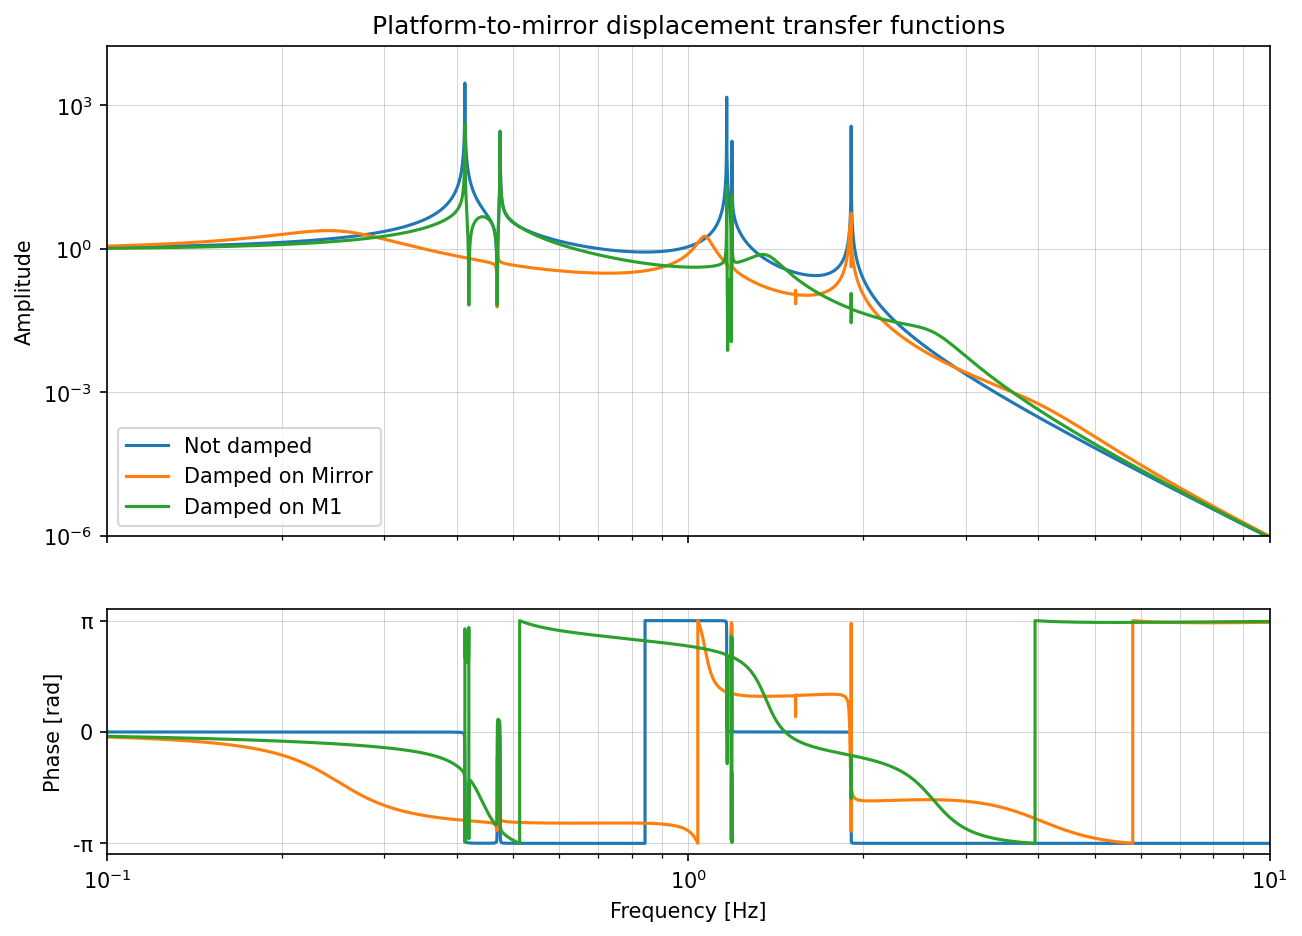

In [25]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10, 7), dpi = 150, sharex=True)

a0.loglog(Frequency_Array, np.squeeze(p_to_m_concatenated_sampled.magnitude), label = 'Not damped')
a0.loglog(Frequency_Array, np.squeeze(p_to_m_m3_act_sampled.magnitude), label = 'Damped on Mirror')
a0.loglog(Frequency_Array, np.squeeze(p_to_m_m1_act_sampled.magnitude), label = 'Damped on M1')


a0.set_ylabel('Amplitude')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_yticks([1e-6, 1e-3, 1, 1e3])
a0.set_xlim(1e-1, 10)
a0.set_ylim(1e-6, )
a0.set_title('Platform-to-mirror displacement transfer functions')

a1.semilogx(Frequency_Array, np.squeeze(p_to_m_concatenated_sampled.phase), label = 'Not damped')
a1.semilogx(Frequency_Array, np.squeeze(p_to_m_m3_act_sampled.phase), label = 'Damped on Mirror')
a1.semilogx(Frequency_Array, np.squeeze(p_to_m_m1_act_sampled.phase), label = 'Damped on Mirror')


a1.grid(True, which = 'both', linewidth = .25)
a1.set_xlabel('Frequency [Hz]')
a1.set_ylabel('Phase [rad]')
a1.set_yticks([-np.pi, 0, np.pi], labels = ["-π", 0, "π"])
a1.set_xlim(1e-1, 10)

plt.show()

In [26]:
#Project the noises: 
mirr_motion_damped_m1_act = platform_motion*np.squeeze(p_to_m_m1_act_sampled.magnitude)
mirr_motion_damped_m3_act = platform_motion*np.squeeze(p_to_m_m3_act_sampled.magnitude)

In [27]:
# Compute and print the residual motion RMSs
mirr_motion_damped_m3_rms = cumulative_rms(mirr_motion_damped_m3_act, freqs)
mirr_motion_damped_m1_rms = cumulative_rms(mirr_motion_damped_m1_act, freqs)

print(f'Platform motion rms = {platform_motion_rms[0]:.4e} m')
print(f'Mirror motion rms (undamped) = {mirr_motion_undamped_rms[0]:.4e} m')
print(f'Mirror motion rms (damped on M3) = {mirr_motion_damped_m3_rms[0]:.4e} m')
print(f'Mirror motion rms (damped on M1) = {mirr_motion_damped_m1_rms[0]:.4e} m')

Platform motion rms = 1.5187e-08 m
Mirror motion rms (undamped) = 3.5267e-08 m
Mirror motion rms (damped on M3) = 2.2216e-08 m
Mirror motion rms (damped on M1) = 1.7508e-08 m


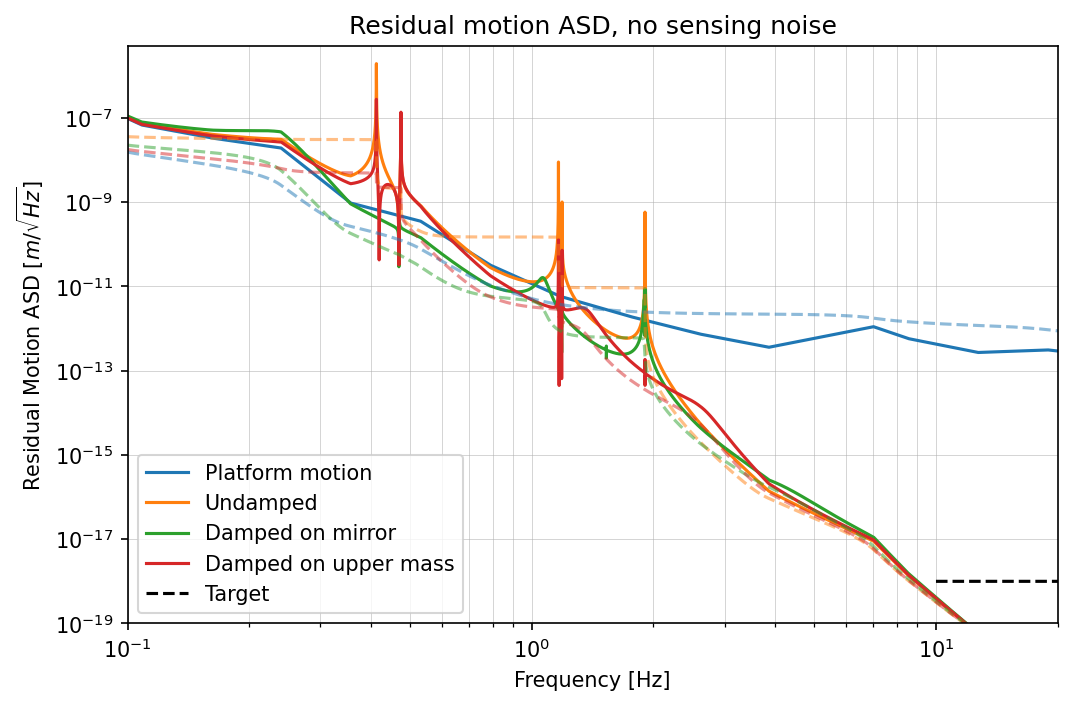

In [28]:
f, a0 = plt.subplots(1, 1, figsize=(8, 5), dpi = 150)

a0.loglog(freqs, platform_motion , label = 'Platform motion')
a0.loglog(freqs, mirr_motion_undamped , label = 'Undamped')
a0.loglog(freqs, mirr_motion_damped_m3_act, label = 'Damped on mirror')
a0.loglog(freqs, mirr_motion_damped_m1_act, label = 'Damped on upper mass')

a0.loglog(freqs[1:], platform_motion_rms ,  linestyle='--', color='C0', alpha=0.5)
a0.loglog(freqs[1:], mirr_motion_undamped_rms , linestyle='--', color='C1', alpha=0.5)
a0.loglog(freqs[1:], mirr_motion_damped_m3_rms,   linestyle='--', color='C2', alpha=0.5)
a0.loglog(freqs[1:], mirr_motion_damped_m1_rms,  linestyle='--', color='C3', alpha=0.5)


threshold_freqs = np.logspace(1,2, 10000)
a0.loglog(threshold_freqs, 1e-18 * np.ones_like(threshold_freqs), color='black', linestyle='--', label='Target')

a0.set_title('Residual motion ASD, no sensing noise')
a0.set_ylabel(r'Residual Motion ASD $[m/\sqrt{Hz}]$')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_xlim(1e-1, 20)
a0.set_ylim(1e-19, 5e-6)
a0.set_xlabel('Frequency [Hz]')


plt.show()

## 5. Sensor noise! <a class="anchor" id="fifth-bullet"></a>

Up to now we assumed that the sensor we use for the feedback system just measures the mirror position. **Unfortunately this is a lie.**

Real sensors also add a certain amount of self-noise to the signal they are measuring, moreover, local sensors measuring the position of the mirror actually measure the distance between the mirror and the structure where the sensor is mounted to, adding to the signal the motion of the body that the sensor is mounted on.

For simplicity we are going to assume that the sensor is rigidly connected to the platform and vibrates together with it. Therefore the measured signal is the sum of three components: mirror motion, platform motion, sensor self-noise(s).

**Exercise 5:**
* Compute the sensor-noise to mirror-motion transfer functions for the two cases of damped on M1 and damped on M3
* Compute the total sensing noise by (quadratically) summing the sensor self-noise with the platform motion.
* Project the sensing noise to the equivalent mirror motion ASD in the case of damped on M1 and M3. 
* Compute the TOTAL residual mirror motion ASDs by (quadratically) summing the projected sensing noise and the projected ground noise (computed in task 4) in the undamped and in the two damped cases.
* As in Exercise 4, compute and compare the total rms of the residual displacements $SNR_x = \sqrt{\sum_i {Axx_i}^2 \Delta f_i}$, this time including the residual displacement due to the sensing noise. Which one is the lowest?

Hins:
* Use the scheme belows show the M1 and M3 control loops considering also the sensing noise contributions:

### Sensing and Actuation on M3 with sensing noise
![Loop_m3_act](topical_lecture_m3_act.drawio.png)

### Sensing and Actuation on M1 with sensing noise
![Loop_m1_act](topical_lecture_m1_act.drawio.png)

## Answers:

In [29]:
# Sensing noise TFs
sens_noise_tf_m1_act = control.minreal(- open_loop_m1_act / (1 + open_loop_m1_act) * m2_to_m3 *1/f_to_d_m2* m1_to_m2 *1/f_to_d_m1,1e-2)
sens_noise_tf_m3_act = control.minreal(- open_loop_m3_act / (1 + open_loop_m3_act),1e-2)

23 states have been removed from the model
22 states have been removed from the model


/data/gravwav/topical_lecture_2024/conda_env/top_lect_shared/lib/python3.12/site-packages/scipy/signal/_filter_design.py:1109: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


In [30]:
# Sample the sensing noise transfer functions and compute the residual noise ASDs

sens_noise_tf_m1_act_sampled = control.frequency_response(sens_noise_tf_m1_act, Omega_Array)
sens_noise_tf_m3_act_sampled = control.frequency_response(sens_noise_tf_m3_act, Omega_Array)

In [31]:
#Enhanced BOSEM shadow sensors can reach  the extreme sensitivity of a flat 5e-11 m/sqrt(Hz) spectra over the whole suspension control bandwidth.
# Let's use this as our sensor self_noise
self_noise = 5e-11 * np.ones_like(freqs)

In [32]:
# Total sensing noise:
sensing_noise = np.sqrt(self_noise**2 + platform_motion**2)

In [33]:
# Project the sensing noise
sensing_noise_m1_act_projected = sensing_noise*np.squeeze(sens_noise_tf_m1_act_sampled.magnitude)
sensing_noise_m3_act_projected = sensing_noise*np.squeeze(sens_noise_tf_m3_act_sampled.magnitude)


# Compute the total noise including residual motion ASD of platform motion and sensing noise contributions to mirror motion
total_noise_m1_act = np.sqrt(mirr_motion_damped_m1_act**2 + sensing_noise_m1_act_projected**2)
total_noise_m3_act = np.sqrt(mirr_motion_damped_m3_act**2 + sensing_noise_m3_act_projected**2)

In [34]:
# Compute and print the RMSs

total_noise_m3_act_rms = cumulative_rms(total_noise_m3_act, freqs)
total_noise_m1_act_rms = cumulative_rms(total_noise_m1_act, freqs)

print(f'Platform motion rms = {platform_motion_rms[0]:.4e} m')
print(f'Mirror motion rms (undamped) = {mirr_motion_undamped_rms[0]:.4e} m')
print(f'Mirror motion rms (damped on M3) with sensing noise = {total_noise_m3_act_rms[0]:.4e} m')
print(f'Mirror motion rms (damped on M1) with sensing noise = {total_noise_m1_act_rms[0]:.4e} m')

Platform motion rms = 1.5187e-08 m
Mirror motion rms (undamped) = 3.5267e-08 m
Mirror motion rms (damped on M3) with sensing noise = 2.3674e-08 m
Mirror motion rms (damped on M1) with sensing noise = 1.8005e-08 m


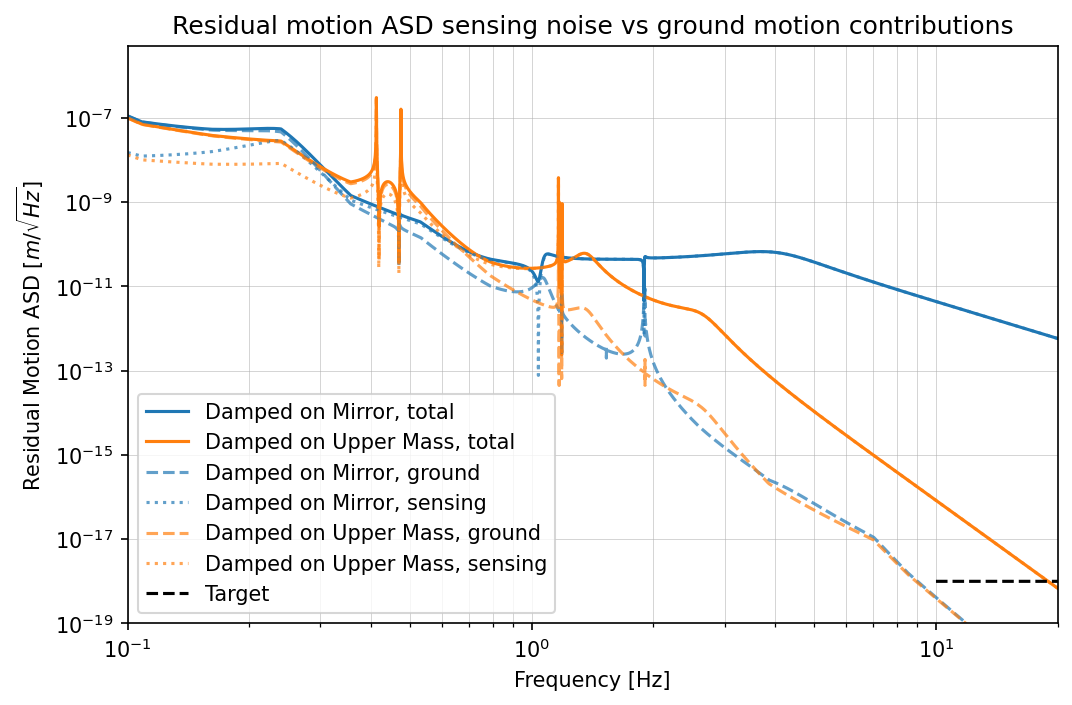

In [35]:
f, a0 = plt.subplots(1, 1, figsize=(8, 5), dpi = 150)

a0.loglog(freqs, total_noise_m3_act, label = 'Damped on Mirror, total', color='C0')
a0.loglog(freqs, total_noise_m1_act, label = 'Damped on Upper Mass, total', color='C1')


a0.loglog(freqs, mirr_motion_damped_m3_act, label = 'Damped on Mirror, ground', linestyle='--', alpha=0.7, color='C0')
a0.loglog(freqs,  sensing_noise_m3_act_projected, label = 'Damped on Mirror, sensing', linestyle=':', alpha=0.7, color='C0')

a0.loglog(freqs, mirr_motion_damped_m1_act, label = 'Damped on Upper Mass, ground', linestyle='--', alpha=0.7, color='C1')
a0.loglog(freqs,  sensing_noise_m1_act_projected, label = 'Damped on Upper Mass, sensing', linestyle=':', alpha=0.7, color='C1')

threshold_freqs = np.logspace(1,2, 10000)
a0.loglog(threshold_freqs, 1e-18 * np.ones_like(threshold_freqs), color='black', linestyle='--', label='Target')

a0.set_title('Residual motion ASD sensing noise vs ground motion contributions')
a0.set_ylabel(r'Residual Motion ASD $[m/\sqrt{Hz}]$')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_xlim(1e-1, 20)
a0.set_ylim(1e-19, 5e-6)
a0.set_xlabel('Frequency [Hz]')


plt.show()

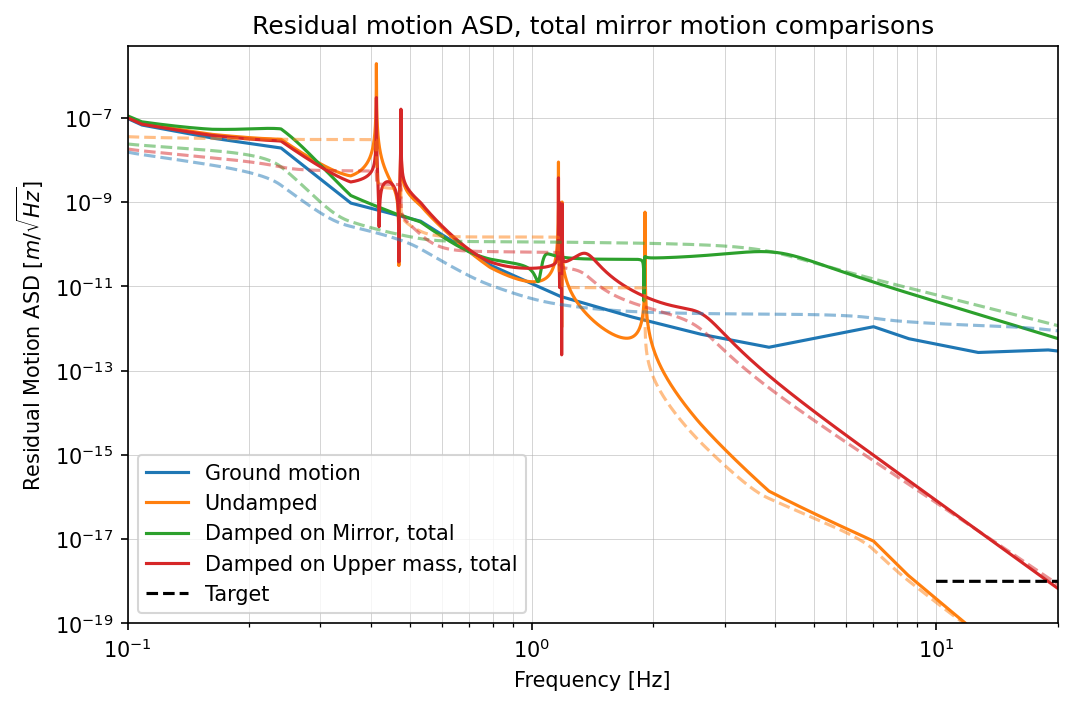

In [36]:
f, a0 = plt.subplots(1, 1, figsize=(8, 5), dpi = 150)

a0.loglog(freqs, platform_motion , label = 'Ground motion')
a0.loglog(freqs, mirr_motion_undamped , label = 'Undamped')
a0.loglog(freqs, total_noise_m3_act, label = 'Damped on Mirror, total')
a0.loglog(freqs, total_noise_m1_act, label = 'Damped on Upper mass, total')

a0.loglog(freqs[1:], platform_motion_rms ,  linestyle='--', color='C0', alpha=0.5)
a0.loglog(freqs[1:], mirr_motion_undamped_rms , linestyle='--', color='C1', alpha=0.5)
a0.loglog(freqs[1:], total_noise_m3_act_rms,   linestyle='--', color='C2', alpha=0.5)
a0.loglog(freqs[1:], total_noise_m1_act_rms,  linestyle='--', color='C3', alpha=0.5)



threshold_freqs = np.logspace(1,2, 10000)
a0.loglog(threshold_freqs, 1e-18 * np.ones_like(threshold_freqs), color='black', linestyle='--', label='Target')

a0.set_title('Residual motion ASD, total mirror motion comparisons')
a0.set_ylabel(r'Residual Motion ASD $[m/\sqrt{Hz}]$')
a0.legend(loc = 'lower left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_xlim(1e-1, 20)
a0.set_ylim(1e-19, 5e-6)
a0.set_xlabel('Frequency [Hz]')


plt.show()